# Predicting User Churn in Digital Music Services

Notebook to document data exploration and development of ML algorithm to identify at risk customers in digital music services.

### Data Definition

From Exploratory Data Analysis (EDA): 
#### Useful:
- *location*: location of user, seems to append each new state (location, state)
- *gender*: user gender (M/F/None)

- *page*: what page the user is on during event (pages)
- *level*: subscription level check uniqueness (free or paid)
- *auth*: authenication (logged in/out)
- *length*: time spent on page, max 50 mins on NextSong (if song paused??)

- *registration*: unknown (registration unixtime)
- *ts*: timestamp of event in ms (event unixtime)

- *userId*: unique (userId val)
- *sessionId*: unique sessionId per user?
- *itemInSession*: lcounter for the number of items in a single session (item listened to in session)


#### Not Useful:
- *firstName*: users first name (not important, remove)
- *lastName*: users lastname
- *artist*: song artist
- *song*: songname
- *userAgent*: device/browser (not important for us, remove)
- *method*: API PUT/GET http request (not important for us, remove)
- *status*: http status

### Imports

In [1]:
# imports
#import ibmos2spark

# pyspark sql
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import from_unixtime, udf, col, when, isnan, desc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql import functions as F

# python
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from typing import NewType
import seaborn as sns
import plotly.express as px

# setup
pysparkdf = NewType('pysparkdf', object)
sns.set_style("darkgrid")

### IBM WatsonSetup

In [2]:
# # config
# # @hidden_cell
# credentials = {
#     'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
#     'service_id': 'iam-ServiceId-147e1161-7da9-41fe-ac00-c144730def00',
#     'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
#     'api_key': 'kAtvjdC8VIYYUmU3gDaOYIK2fCvP3nkjYYlDiNuu4gw6'
# }

# configuration_name = 'os_76774389dfa04fb5acbb1640b3e11704_configs'
# cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

### Start Session

In [3]:
# Build Spark session
spark = SparkSession.builder.appName("user_churn").getOrCreate()

# Read in data from IBM Cloud
# data_df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-fnqu5byx41gcai'))

user_log_valid = spark.read.parquet("../data/03_primary/medium-sparkify-event-data-wrangled.parquet")

In [4]:
user_log_valid.printSchema()

root
 |-- authLevel: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- sessionLength_s: double (nullable = true)
 |-- subLevel: string (nullable = true)
 |-- page: string (nullable = true)
 |-- unixRegistrationTS: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- unixEventTS: long (nullable = true)
 |-- userId: string (nullable = true)
 |-- timestampDatetime: string (nullable = true)
 |-- registrationDatetime: string (nullable = true)
 |-- usStateAbbr: string (nullable = true)



# ML Feature Engineering

### Flag user Cancellations and Identify Churned Users

In [5]:
def create_phase_feature(user_log_valid: pysparkdf) -> pysparkdf:
    """Use the cancellation to identify churned users.
    """
    flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    user_log_valid = user_log_valid.withColumn("churn", flag_cancellation_event("page"))

    windowval = Window.partitionBy("userId").orderBy(desc("unixEventTS")).rangeBetween(Window.unboundedPreceding, 0)
    return user_log_valid.withColumn("label", Fsum("churn").over(windowval))
    
user_log_valid = create_phase_feature(user_log_valid)

In [6]:
user_log_valid.filter(user_log_valid['userId']==100010).select('userId','page', 'unixEventTS', 'churn', 'label').orderBy('unixEventTS', ascending=False).show(10)

+------+--------------------+-------------+-----+-----+
|userId|                page|  unixEventTS|churn|label|
+------+--------------------+-------------+-----+-----+
|100010|Cancellation Conf...|1539254318000|    1|    1|
|100010|              Cancel|1539254305000|    0|    1|
|100010|         Roll Advert|1539254304000|    0|    1|
|100010|            NextSong|1539254279000|    0|    1|
|100010|            NextSong|1539254097000|    0|    1|
|100010|         Roll Advert|1539253766000|    0|    1|
|100010|            NextSong|1539253749000|    0|    1|
|100010|            NextSong|1539253561000|    0|    1|
|100010|         Thumbs Down|1539253352000|    0|    1|
|100010|            NextSong|1539253351000|    0|    1|
+------+--------------------+-------------+-----+-----+
only showing top 10 rows



### Define Features

In [7]:
def avg_items_in_session(user_log_valid: pysparkdf)-> pysparkdf:
    """calculate avg items in session for each user.
    """
    return user_log_valid.join(user_log_valid.groupBy('userId').avg('itemInSession'),
                               on='userId')

In [8]:
def avg_user_listening_time(user_log_valid: pysparkdf) -> pysparkdf:
    """calculate average listening time.
    """
    return user_log_valid.join(user_log_valid.groupBy('userId').avg('sessionLength_s'),
                               on='userId')

In [9]:
def recommendation_performance_good(user_log_valid: pysparkdf) -> pysparkdf:
    """Number of Positive Events.
    """
    user_log_valid = user_log_valid.withColumn("recc_performance_good_events",
                                         when((user_log_valid["page"] == 'Add to Playlist') |\
                                              (user_log_valid["page"] == 'Add Friend') |\
                                              (user_log_valid["page"] == 'Thumbs Up'),
                                              1).otherwise(0))
    
    return user_log_valid.join(user_log_valid.groupBy('userId').sum('recc_performance_good_events'),
                               on='userId')

def recommendation_performance_bad(user_log_valid: pysparkdf) -> pysparkdf:
    """Number of Positive Events.
    """
    user_log_valid = user_log_valid.withColumn("recc_performance_bad_events",
                                         when((user_log_valid["page"] == 'Thumbs Down'),
                                              1).otherwise(0))

    return user_log_valid.join(user_log_valid.groupBy('userId').sum('recc_performance_bad_events'),
                               on='userId')

In [10]:
def system_performance_bad(user_log_valid: pysparkdf) -> pysparkdf:
    """Number of Positive Events.
    """
    user_log_valid = user_log_valid.withColumn("sys_performance_bad",
                                         when((user_log_valid["page"] == 'Help') |\
                                              (user_log_valid["page"] == 'Upgrade') |\
                                              (user_log_valid["page"] == 'Error'),
                                              1).otherwise(0))
    return user_log_valid.join(user_log_valid.groupBy('userId').sum('sys_performance_bad'),
                               on='userId')   

In [11]:

user_log_valid.where(user_log_valid['userId']==100010).groupBy('sessionId').agg(F.min('unixEventTS')).show()

+---------+----------------+
|sessionId|min(unixEventTS)|
+---------+----------------+
|       62|   1538991392000|
|      166|   1539242427000|
+---------+----------------+



In [12]:
user_log_valid.where(user_log_valid['userId']==100010).select('page', 'timestampDatetime', 'sessionId').orderBy('timestampDatetime').head(5000)

[Row(page='NextSong', timestampDatetime='2018-10-08 10:36:32', sessionId=62),
 Row(page='NextSong', timestampDatetime='2018-10-08 10:40:18', sessionId=62),
 Row(page='NextSong', timestampDatetime='2018-10-08 10:45:03', sessionId=62),
 Row(page='NextSong', timestampDatetime='2018-10-08 10:48:59', sessionId=62),
 Row(page='NextSong', timestampDatetime='2018-10-08 10:53:09', sessionId=62),
 Row(page='NextSong', timestampDatetime='2018-10-08 10:56:56', sessionId=62),
 Row(page='NextSong', timestampDatetime='2018-10-08 10:59:57', sessionId=62),
 Row(page='NextSong', timestampDatetime='2018-10-08 11:04:24', sessionId=62),
 Row(page='Roll Advert', timestampDatetime='2018-10-08 11:04:36', sessionId=62),
 Row(page='NextSong', timestampDatetime='2018-10-08 11:08:32', sessionId=62),
 Row(page='NextSong', timestampDatetime='2018-10-08 11:11:25', sessionId=62),
 Row(page='Home', timestampDatetime='2018-10-08 11:11:36', sessionId=62),
 Row(page='NextSong', timestampDatetime='2018-10-08 11:14:47', se

In [13]:

# process
user_log_valid = avg_items_in_session(user_log_valid)
user_log_valid = avg_user_listening_time(user_log_valid)

user_log_valid = recommendation_performance_good(user_log_valid)
user_log_valid = recommendation_performance_bad(user_log_valid)
user_log_valid = system_performance_bad(user_log_valid)



In [14]:
user_log_valid.head(1)

[Row(userId='100010', authLevel='Cancelled', gender='F', itemInSession=67, sessionLength_s=None, subLevel='free', page='Cancellation Confirmation', unixRegistrationTS=1538016340000, sessionId=166, unixEventTS=1539254318000, timestampDatetime='2018-10-11 11:38:38', registrationDatetime='2018-09-27 03:45:40', usStateAbbr='CT', churn=1, label=1, avg(itemInSession)=33.839416058394164, avg(sessionLength_s)=269.4890702083333, recc_performance_good_events=0, sum(recc_performance_good_events)=8, recc_performance_bad_events=0, sum(recc_performance_bad_events)=3, sys_performance_bad=0, sum(sys_performance_bad)=2)]

In [15]:
ml_features_data = user_log_valid.select('label',
'userId',
'gender',
'usStateAbbr',
col('avg(itemInSession)').alias("avg_item_in_session"),
col('avg(sessionLength_s)').alias('avg_session_length'),
col('sum(recc_performance_good_events)').alias('num_good_recc'),
col('sum(recc_performance_bad_events)').alias('num_bad_recc'),
col('sum(sys_performance_bad)').alias('num_bad_sys')
)

In [16]:
ml_features_data.head()

Row(label=1, userId='100010', gender='F', usStateAbbr='CT', avg_item_in_session=33.839416058394164, avg_session_length=269.4890702083333, num_good_recc=8, num_bad_recc=3, num_bad_sys=2)

## Review Features

In [17]:
def review_features(count_on=None, group_on=None, bins=None):
    df = ml_features_data.groupby(group_on).agg(F.countDistinct(count_on)).toPandas()
    px.histogram(df, x=group_on, y='count({})'.format(count_on), nbins=bins).update_layout(width=400, height=400).show()


### Categorical Features

In [18]:
review_features(count_on='userId', group_on='gender')

In [19]:
review_features(count_on='userId', group_on='num_bad_sys', bins=50)


In [20]:
review_features(count_on='userId', group_on='num_good_recc', bins=50)

### Numerical Features

In [49]:
user_stats = ml_features_data.groupBy('userId').avg().toPandas()

In [51]:
user_stats = user_stats.drop(labels="userId", axis=)

In [58]:
user_stats.head()

,avg(label),avg(avg_item_in_session),avg(avg_session_length),avg(num_good_recc),avg(num_bad_recc),avg(num_bad_sys)
0,1.0,33.839416,269.489070,8.0,3.0,2.0
1,1.0,54.832911,253.857506,23.0,5.0,3.0
2,1.0,27.644737,252.804911,13.0,0.0,3.0
3,0.0,27.297619,255.060824,8.0,1.0,2.0
4,1.0,126.100649,250.089836,173.0,15.0,10.0


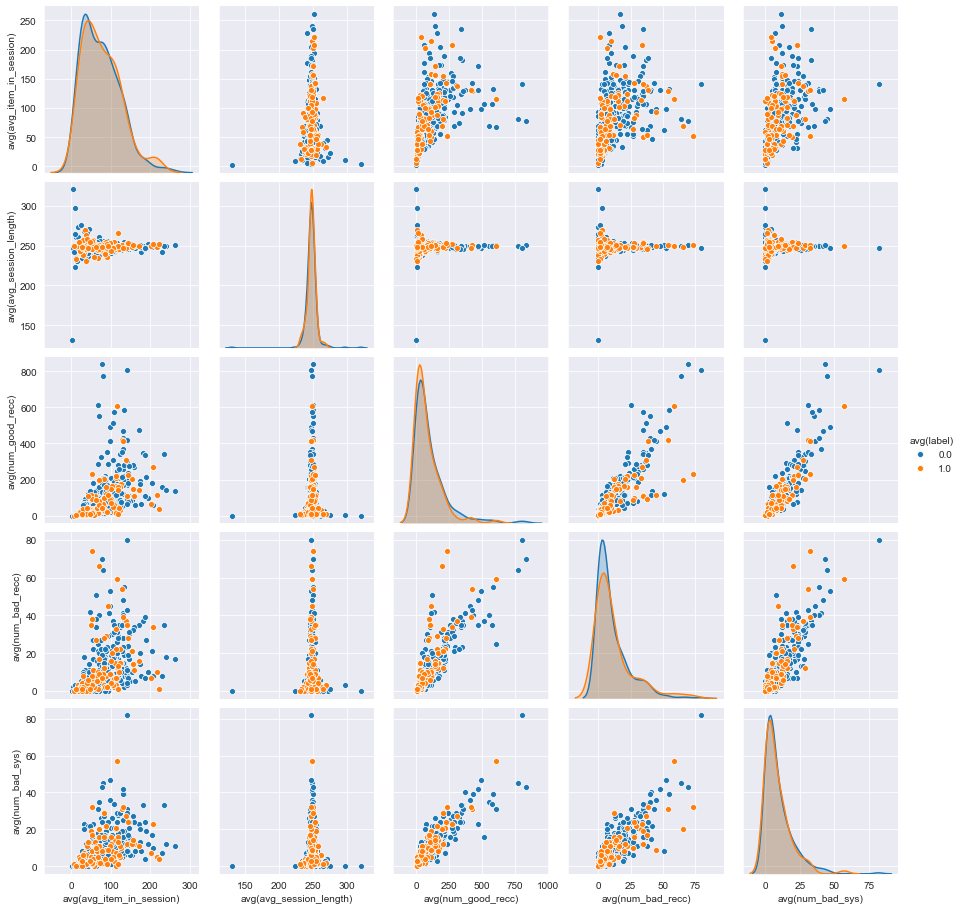

In [59]:
sns.pairplot(user_stats, hue="avg(label)");

## Data Validity Check

In [60]:
def check_data_validity(df):
    print(df.select([F.count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).head())

check_data_validity(ml_features_data)

Row(label=0, userId=0, gender=0, usStateAbbr=0, avg_item_in_session=0, avg_session_length=0, num_good_recc=0, num_bad_recc=0, num_bad_sys=0)


In [61]:
ml_features_data = ml_features_data.dropna(how="any")

In [62]:
check_data_validity(ml_features_data)

Row(label=0, userId=0, gender=0, usStateAbbr=0, avg_item_in_session=0, avg_session_length=0, num_good_recc=0, num_bad_recc=0, num_bad_sys=0)


In [63]:
ml_features_data.write.parquet("../data/04_primary/medium-sparkify-event-data-features.parquet", mode='overwrite')